In [254]:
# SPEC NORM RV CALCULATIONS

import numpy as np
from datetime import datetime, date, time, timedelta
import astropy.coordinates as astrocoord
from astropy.time import Time
from astropy import units as u
from scipy.signal import find_peaks
from copy import deepcopy
from spec_tools import Spectrum
from scipy import interpolate
import scipy.ndimage as nd
import sys
from turbospec_wrapper.turbospec_tools import SpectrumTS
from astropy.io import fits
import scipy.stats as stats
from matplotlib import pyplot as plt
sys.path.insert(0, '../apogee/python/')

import doppler

GEMINI_SOUTH_LOC = astrocoord.EarthLocation.from_geodetic((-70, 44, 12.096),
                                                          (-30, 14, 26.700),
                                                          height=2722.,
                                                          ellipsoid='WGS84')

class SpecNormRV(Spectrum):
    def poly_normalize(self, order=4, norm=True, inspect=False):
        param = np.polyfit(self.wavelength, self.flux, order, w=1/np.sqrt(self.variance))
        self.poly_norm_coeff = param
        orig_flux = self.flux
        orig_var = self.variance
        poly_scaling = np.polyval(param, self.wavelength)
        if norm:
            self.flux /= poly_scaling
            self.variance /= poly_scaling**2.
        if inspect:
            return self.wavelength, orig_flux, orig_var, poly_scaling
    
    def add_template(self, template):
        self.original_template = template
        self._interpolate_template()
        
    def rv_correct(self, wave_range=None, vel_range=None, inspect=False, 
                   shift_wavelength=True, fill_nan=True, fill_value=1):
        
        if wave_range is None:
            wave_range = [3500, 10600]
            
        if vel_range is None:
            vel_range = [-500, 500]
        
        inwave = self.wavelength
        intemp = self.template.flux
        inspec = self.flux
        inerr = np.sqrt(self.variance)

        if fill_nan:
            inspec = np.array(inspec)
            inspec[~np.isfinite(inspec)] = 1
            inerr[~np.isfinite(inspec)] = 1.e6


        # sel = (inwave > 4000) & (inwave < 5300)
        # sel = inwave > 0
        # sel = (inwave > 4100) & (inwave < 4130)

        wave_mask = (inwave > wave_range[0]) & (inwave < wave_range[1])

        out = doppler.rv.specxcorr(wave=inwave[wave_mask],
                                   tempspec=intemp[wave_mask],
                                   obsspec=inspec[wave_mask], 
                                   obserr=inerr[wave_mask],
                                   plot=inspect,
                                   maxlag=vel_range)
        
        self.rv = out['vrel'][0]
        self.rv_err = out['vrelerr'][0]
        if shift_wavelength:
            self.wavelength=self.vel_shift(-1.*self.rv)
            self._interpolate_template()
        
    def barycenter_correction(self, ra, dec, date_obs, utstart, exptime, verbose=False):
        # Set up a SkyCoord for this ad
        sc = astrocoord.SkyCoord(ra, dec,
                                 unit=(u.hr, u.deg, ))

        # Compute central time of observation
        dt_start = datetime.combine(
            datetime.strptime(date_obs, '%Y-%m-%d').date(),
            datetime.strptime(utstart, '%H:%M:%S').time(),
        )

        dt_midp = dt_start + timedelta(
            seconds=exptime/2.0
        )
        dt_midp = Time(dt_midp)

        # Vanilla AstroPy Implementation
        corr_fact = sc.radial_velocity_correction('barycentric',
                                                  obstime=dt_midp,
                                                  location=GEMINI_SOUTH_LOC)

        corr_fact = corr_fact.to(u.km / u.s)
        
        self.rv_bary = self.rv + corr_fact.value
            
        if verbose:
            print(f'Correction Factor = {corr_fact:.2f}')
            print(f'RV = {self.rv:.2f}')
            print(f'Barycentric RV = {self.rv_bary:.2f}')

        
    def spline_normalize(self, spec_gauss_smooth=3, continuum_threshold=0.99,
                         snr_threshold=2, iterations=10, snr_smoothing=101,
                         sig_clip_low=2, sig_clip_high=10, spline_smooth_factor=2.):
                
                
        snr = nd.median_filter(self.flux, snr_smoothing)/np.sqrt(nd.median_filter(self.variance, snr_smoothing))

        continuum_points = nd.gaussian_filter(self.template.flux,sigma=spec_gauss_smooth) > continuum_threshold   
        continuum_points &= (snr>snr_threshold)
        continuum_points &= ((self.wavelength < 7580) | (self.wavelength > 7725))
        continuum_points &= ((self.wavelength < 9250) | (self.wavelength > 9600))

#         [7580, 7725]
#         [8900, 9900]

        
        x = np.array(self.wavelength[continuum_points])
        y = np.array(nd.gaussian_filter(self.flux,spec_gauss_smooth)[continuum_points])
        w = np.array(nd.gaussian_filter(self.variance,spec_gauss_smooth)[continuum_points])

        y[w==0.] = 0.
        w[w==0.] = 1e6

        for i in range(iterations):
            spl = interpolate.UnivariateSpline(x,y,w=1/np.sqrt(w), 
                                               s = len(x)*spline_smooth_factor)
            
            newy = spl(x)
            a, low, high = stats.sigmaclip(y - newy, low=sig_clip_low, high=sig_clip_high)
            if i != iterations-1:
                x = x[((y - newy) > low) & ((y - newy) < high)]
                w = w[((y - newy) > low) & ((y - newy) < high)]
                y = y[((y - newy) > low) & ((y - newy) < high)]


        self.continuum_spline = spl
        self.continuum = spl(self.wavelength)
        self.norm_spectrum = Spectrum(self.wavelength, self.flux/self.continuum,
                                      variance=self.variance/self.continuum**2.)
        
    
    def _interpolate_template(self):
        
        ip = interpolate.InterpolatedUnivariateSpline(self.original_template.wavelength,
                                                      self.original_template.flux,k=3, ext=0)
        self.template = Spectrum(self.wavelength, ip(self.wavelength))
        
        
def combine_ghost(blue_spec, red_spec, oversample=1):
    # Determine the wavelength bounds of the file
    min_wavl, max_wavl = np.min(blue_spec.wavelength), np.max(red_spec.wavelength)
    blue_spacing = np.log(blue_spec.wavelength[1:]) - np.log(blue_spec.wavelength[:-1])
    red_spacing = np.log(red_spec.wavelength[1:]) - np.log(red_spec.wavelength[:-1])

    logspacing = np.maximum(blue_spacing.max(),red_spacing.max())
    # Form a new wavelength scale based on these extremes
    wavl_grid = np.exp(
        np.linspace(np.log(min_wavl), np.log(max_wavl),
                    num=int(
                        (np.log(max_wavl) - np.log(min_wavl)) /
                        (logspacing / float(oversample))
                    ))
    )

    # Create a final spectrum and (inverse) variance to match
    # (One plane per object)
    spec_final = np.zeros(wavl_grid.shape)
    var_final = np.inf * np.ones(wavl_grid.shape)

    # Loop over each input order, making the output spectrum the
    # result of the weighted average of itself and the order
    # spectrum
    for spec in [blue_spec,red_spec]:
        flux_for_adding = np.interp(wavl_grid,
                                    spec.wavelength,
                                    spec.flux,
                                    left=0, right=0)
        ivar_for_adding = np.interp(wavl_grid,
                                    spec.wavelength,
                                    1.0 /
                                    spec.variance,
                                    left=0, right=0)
        spec_comp, ivar_comp = np.ma.average(
            np.asarray([spec_final, flux_for_adding]),
            weights=np.asarray([1.0 / var_final,
                                ivar_for_adding]),
            returned=True, axis=0,
        )
        spec_final = deepcopy(spec_comp)
        var_final = deepcopy(1.0 / ivar_comp)
        
    return Spectrum(wavl_grid, spec_final, variance=var_final)




# RUNNING SPEC NORM RV AND VISUALIZING

In [ ]:
blue_spec_filename = 'example_blue.txt'
red_spec_filename = 'example_red.txt'
template_filename = 'metal_poor_template.spec.convol'
output_filename = 'example_spec_normrv.txt'

In [255]:
data_blue = np.genfromtxt('example_blue.txt', dtype=None, encoding=None, names=True)
data_red = np.genfromtxt('example_red.txt', dtype=None, encoding=None, names=True)

data_blue['variance'][data_blue['variance'] == 0.] = 1.e6
data_red['variance'][data_red['variance'] == 0.] = 1.e6

data_blue['flux'][~np.isfinite(data_blue['flux'])] = 0.0
data_red['flux'][~np.isfinite(data_red['flux'])] = 0.0

data_blue['variance'][~np.isfinite(data_blue['variance'])] = 1.e6
data_red['variance'][~np.isfinite(data_red['variance'])] = 1.e6


cand_blue = SpecNormRV(data_blue['wavelength'], data_blue['flux'], variance=data_blue['variance'])
cand_red = SpecNormRV(data_red['wavelength'], data_red['flux'], variance=data_red['variance'])

template = SpectrumTS(template_filename)


In [256]:
cand_blue.poly_normalize()
cand_red.poly_normalize()


# Calculate RVs from cross-corellation

You can change the wavelength range over which you do the cross-correlation, red and blue cameras are calculated separately

Note that if you want to rerun this you have to re-read in the spectra in the cells above first.

52603 52603 3923.3502523622237
[4000.01142953 4000.03282846 4000.05422751 ... 5299.91944646 5299.94779953
 5299.97615276]
40165 40165 93.72541610960322
[5500.02762353 5500.05667722 5500.08573107 ... 6799.89284721 6799.9287674
 6799.96468777]


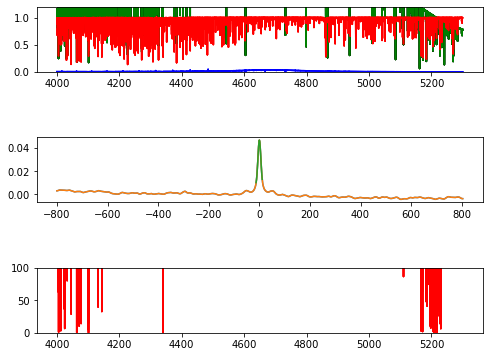

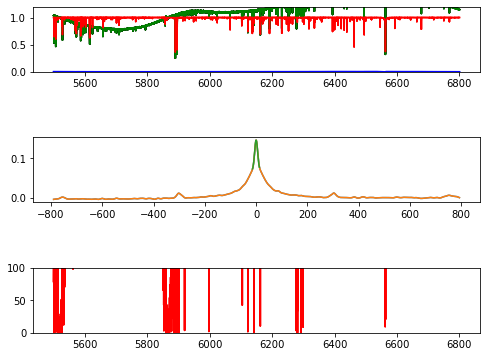

In [257]:
cand_blue.add_template(template)
cand_red.add_template(template)

cand_blue.rv_correct(wave_range=[4000, 5300], inspect=True)
cand_red.rv_correct(wave_range=[5500, 6800], inspect=True)


In [258]:
print(cand_blue.rv)
print(cand_red.rv)


0.04081590292652623
0.14448797582638137


# Read in observing information for barycenter correction

Need to change IFU1RA/DEC to be either IFU1 or IFU2 depending on which IFU your object was in

In [259]:
with fits.open('example_ghost_spectrum_blue002_formattedOutput.fits') as file:
    header = file[0].header
    blue_ra = header['IFU1RA']
    blue_dec = header['IFU1DEC']
    blue_exptime = header['EXPTIME']
    blue_dateobs = header['DATE-OBS']
    blue_utstart = header['UTSTART']

with fits.open('example_ghost_spectrum_red002_formattedOutput.fits') as file:
    header = file[0].header
    red_ra = header['IFU1RA']
    red_dec = header['IFU1DEC']
    red_exptime = header['EXPTIME']
    red_dateobs = header['DATE-OBS']
    red_utstart = header['UTSTART']


In [260]:
cand_blue.barycenter_correction(blue_ra, blue_dec, blue_dateobs, blue_utstart, blue_exptime)
cand_red.barycenter_correction(red_ra, red_dec, red_dateobs, red_utstart, red_exptime)


In [261]:
print(cand_blue.rv_bary)
print(cand_red.rv_bary)


-26.29487358355544
-26.18974330916209


# Fine Continuum Normalization
Enter in continuum threshold (in the template spectrum) and smoothing factor (lower smoothing factor = more bends in the continuum normalization)

You'll need to change these values until you like the continuum fit

In [265]:

cand_blue.spline_normalize(continuum_threshold=0.99, spline_smooth_factor=2.1)
cand_red.spline_normalize(continuum_threshold=0.99, spline_smooth_factor=3.4)

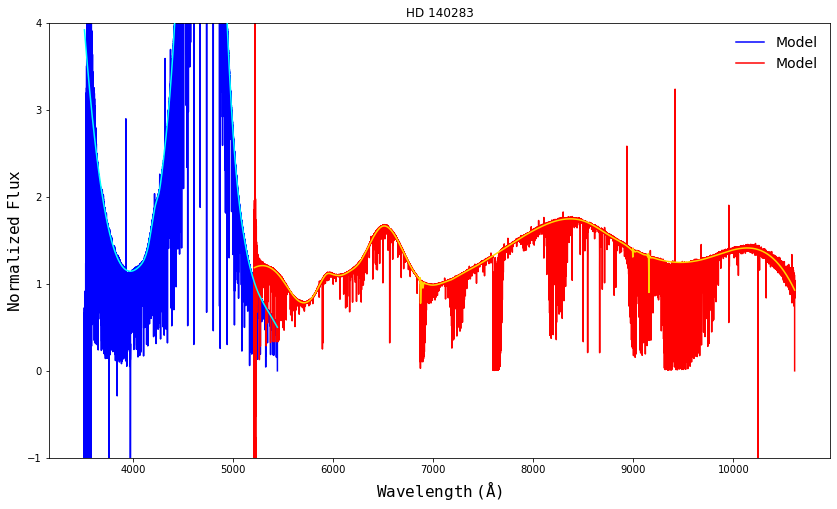

In [264]:
color_plots = ['red', 'orange', 'gold', 'cyan', 'dodgerblue', 'mediumorchid']
import matplotlib
%matplotlib inline

# Make your figure and the axes that you are going to plot on
fig = plt.figure(figsize = (14,8))

ax = fig.add_subplot(111)

ax.plot(cand_blue.wavelength, cand_blue.flux, c='b', label='Model')
ax.plot(cand_blue.wavelength, cand_blue.continuum, c='cyan', zorder=4)

ax.plot(cand_red.wavelength, cand_red.flux, c='r', label='Model')
ax.plot(cand_red.wavelength, cand_red.continuum, c='gold', zorder=4)

ax.set_xlabel(r'$\mathtt{Wavelength \ (\AA)}$', fontsize=16)
ax.set_ylabel(r'$\mathtt{Normalized \ \ Flux}$', fontsize=16)

leg = ax.legend(loc=1, numpoints=1, framealpha=0.5, prop={'size':14})
leg.get_frame().set_linewidth(0.0)

ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)

# ax.set_xlim([4200, 4350])
# ax.set_xlim([4400, 4500])
# ax.set_xlim([4720, 4780])


# ax.set_xlim([10600, 10620])

# ax.set_ylim([-100, 1000])
ax.set_ylim([-1,4])

plt.show()

In [266]:
cand = combine_ghost(cand_blue.norm_spectrum, cand_red.norm_spectrum)

# Print out blue/red combined, normalized, RV corrected spectrum

The barycentric RV is also printed out into a header (blue and red camera separately) along with the raw cross-calibration RV uncertainty, though you should probably treat this as an underestimate of the RV uncertainty (often the differences between the red and the blue cameras will be larger than this)

In [ ]:
with open(output_filename, 'w') as outfile:
    print(f'# vbary_blue = {cand_blue.rv_bary:.3f} +/- {cand_blue.rv_err:.3f}', file=outfile)
    print(f'# vbary_red = {cand_red.rv_bary:.3f} +/- {cand_red.rv_err:.3f}', file=outfile)
    print('# wavelength flux variance', file=outfile)
    for wave, flux, var in zip(cand.wavelength, cand.flux, cand.variance):
        if (~np.isfinite(flux)) | (~np.isfinite(var)):
            continue
        else:
            print(wave, flux, var, file=outfile)